DATTABAYÖ - Borja Esteve Molner & Jorge López Fresco

# Sesión 4/5 - Práctica 3 - LNR
## Combinación de Clasificadores

___________

**Objetivo**: Implementar y evaluar la combinación de modelos de clasificación en la tarea DETESTS (al menos dos técnicas diferentes). Entregar código e informe con la explicación de la estrategia utilizada antes de la siguiente sesión.

**Importar Librerías**

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para llevar a cabo esta **cuarta tarea**, vamos a partir de los 2 modelos de representación con Word Embedding (ponderada y mediana). Descartamos directamente el de 3-gramas por dos razones:

- El coste computacional es altísimo y el tiempo de ejecución nos entorpece mucho a la hora de tomar decisiones.
- Los resultados obtenidos con este modelo de representación son los peores de todas las representaciones.

Así, a lo largo del trabajo, usando las **técnicas de combinación de clasificadores**, trataremos de crear modelos que mejoren o iguales a los obtenidos en la sesión anterior. Por otro lado, y dado que debemos **presentar 3 modelos al finalizar la práctica**, hemos decidido que si los modelos obtenidos con la representación de Word Embedding Ponderada son los mejores, descartaremos la representación en la que usamos la mediana. 

A continuación, cargaremos las representaciones de palabras de Word Embedding (mediana y ponderada), que representa a la matriz X:

In [ ]:


# Representación con Word Embedding - Ponderada
data_pond = np.loadtxt(rutaNumpys + "rep_pond_w_emb.txt")
# Representación con Word Embedding - Mediana
data_med = np.loadtxt(rutaNumpys + "rep_median_w_emb.txt")

Además de la matriz `X`, necesitaremos un vector de etiquetas `Y` que contendrá valores binarios de la pertenencia o no a la clase "stereotype". Para ello cargaremos el dataset original de Training `train.csv`.

In [ ]:
df_detests = pd.read_csv(rutaData + "train.csv")
extra_Data = pd.DataFrame(df_detests['stereotype']).to_numpy()

Para estructurar la práctica, llevaremos a cabo el siguiente proceso:

1. Aplicaremos las técnicas de combinación de clasificadores tanto para word embedding ponderada como para la mediana.
2. Dado que nuestro mejor clasificador está en la representación Ponderada, compararemos el mejor resultado de la combinación de clasificadores (previa validación con k-fold) con la ponderada, eligiendo el mejor modelo de los dos. 
3. Ambos serán elegidos como finalistas. 
4. Por otro lado, el mejor modelo de combinación de clasificadores en Word Embedding mediana será comparado con el 2º mejor de combinar clasificadores en Word Embedding Ponderada. 
5. En caso de resultar mejor el de la mediana, el 3º finalista será el modelo resultante de combinar clasificadores con la w.e. mediana. 
6. En caso de resultar mejor el 2º de la ponderada, el 3º finalista será este último, descartando por completo los modelos de representación de word embedding con la mediana.

## Combinación de Clasificadores para Representación con Word Embedding - Ponderada

In [ ]:
data1 = np.append(data_pond, extra_Data, axis=1)
X, y = data1[0:3817,0:300], data1[0:3817,300:301]
print(data_pond.shape, data1.shape)

(3817, 300) (3817, 301)


In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
x_train, x_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3, random_state=42)

### Bagging

In [ ]:
clf = BaggingClassifier(base_estimator=svm.SVC(),n_estimators=10)
clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=SVC())

In [ ]:
pred = clf.predict(x_eval)
acc_sig_svm = clf.score(x_eval, y_eval)
pred_sc = pred
print("Training set score: %f" % clf.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm)
print("F1 Score Macro:", f1_score(y_eval, pred, average='macro'))
print("F1 Score Micro:", f1_score(y_eval, pred, average='micro'))
print("F1 Score:", f1_score(y_eval, pred, average=None))
print("\n", confusion_matrix(y_eval, pred_sc))
print(classification_report(y_eval, pred_sc))

Training set score: 0.881582
Accuracy Radial Basis Kernel: 0.8545557441992077
F1 Score Macro: 0.8545438180826403
F1 Score Micro: 0.8545557441992078
F1 Score: [0.85322673 0.85586091]

 [[747 147]
 [110 763]]
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       894
         1.0       0.84      0.87      0.86       873

    accuracy                           0.85      1767
   macro avg       0.86      0.85      0.85      1767
weighted avg       0.86      0.85      0.85      1767



### Boosting

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=1.5, random_state=1)
ada.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         random_state=0),
                   learning_rate=1.5, n_estimators=500, random_state=1)

In [ ]:
pred_b = ada.predict(x_eval)
acc_sig_svm_b = ada.score(x_eval, y_eval)
pred_sc_b = pred_b
print("Training set score: %f" % ada.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm_b)
print("F1 Score Macro:", f1_score(y_eval, pred_b, average='macro'))
print("F1 Score Micro:", f1_score(y_eval, pred_b, average='micro'))
print("F1 Score:", f1_score(y_eval, pred_b, average=None))
print("\n", confusion_matrix(y_eval, pred_sc_b))
print(classification_report(y_eval, pred_sc_b))

Training set score: 0.999515
Accuracy Radial Basis Kernel: 0.8907753254102999
F1 Score Macro: 0.8907012527830989
F1 Score Micro: 0.8907753254102999
F1 Score: [0.8878559  0.89354661]

 [[764 130]
 [ 63 810]]
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89       894
         1.0       0.86      0.93      0.89       873

    accuracy                           0.89      1767
   macro avg       0.89      0.89      0.89      1767
weighted avg       0.89      0.89      0.89      1767



### Stacking

In [ ]:
treeStack = DecisionTreeClassifier(max_depth=5, random_state=0)
estimators = [('mlp',MLPClassifier(random_state=1, max_iter=1000)),('svr', svm.SVC())]
stack = StackingClassifier ( estimators=estimators, final_estimator=treeStack )
stack.fit(x_train, y_train)

StackingClassifier(estimators=[('mlp',
                                MLPClassifier(max_iter=1000, random_state=1)),
                               ('svr', SVC())],
                   final_estimator=DecisionTreeClassifier(max_depth=5,
                                                          random_state=0))

In [ ]:
pred = stack.predict(x_eval)
acc_sig_svm = stack.score(x_eval, y_eval)
pred_sc = pred
print("Training set score: %f" % stack.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm)
print("F1 Score Macro:", f1_score(y_eval, pred, average='macro'))
print("F1 Score Micro:", f1_score(y_eval, pred, average='micro'))
print("F1 Score:", f1_score(y_eval, pred, average=None))
print("\n", confusion_matrix(y_eval, pred_sc))
print(classification_report(y_eval, pred_sc))

Training set score: 0.995147
Accuracy Radial Basis Kernel: 0.9145444255800792
F1 Score Macro: 0.914481319621729
F1 Score Micro: 0.9145444255800792
F1 Score: [0.91680441 0.91215823]

 [[832  62]
 [ 89 784]]
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       894
         1.0       0.93      0.90      0.91       873

    accuracy                           0.91      1767
   macro avg       0.92      0.91      0.91      1767
weighted avg       0.91      0.91      0.91      1767



A la vista de los resultados, podemos observar que usando la técnica de Stacking obtenemos un modelo que supera al que habíamos entrenado en la sesión anterior. No obstante, y para asegurarnos de que no se trata de un modelo sobreajustado, procederemos a realizar una validación usando, como en la sesión anterior, un 10-fold y evaluando la simitud o disimilitud de los valores del accuracy y el F1.

### Validación Modelo Stacking (mejor modelo)




In [ ]:
kf = KFold(n_splits=10)

a, fma, fmi = [], [], []
for train, eval in kf.split(x_train):
    x_train_i, x_eval_i, y_train_i, y_eval_i = x_train[train], x_train[eval], y_train[train], y_train[eval]
    treeS = DecisionTreeClassifier(max_depth=5, random_state=0)
    estims = [('mlp',MLPClassifier(random_state=1, max_iter=1000)),('svr', svm.SVC())]
    s = StackingClassifier ( estimators=estims, final_estimator=treeS )
    s.fit(x_train_i, y_train_i)
    p = s.predict(x_eval_i)
    acc = s.score(x_eval_i, y_eval_i)
    f1ma = f1_score(y_eval_i, p, average='macro')
    f1mi = f1_score(y_eval_i, p, average='micro')
    a.append(acc)
    fma.append(f1ma)
    fmi.append(f1mi)
print(a)
print(fma)
print(fmi)

[0.9079903147699758, 0.9174757281553398, 0.883495145631068, 0.8859223300970874, 0.912621359223301, 0.9101941747572816, 0.9077669902912622, 0.8980582524271845, 0.9393203883495146, 0.8956310679611651]
[0.9079638752052546, 0.9166904557997906, 0.8833191730387993, 0.8855657004402682, 0.912621359223301, 0.9101301120720657, 0.9069756387403446, 0.8979981608544954, 0.9388270230141054, 0.8953047897645008]
[0.9079903147699758, 0.9174757281553398, 0.883495145631068, 0.8859223300970874, 0.912621359223301, 0.9101941747572816, 0.9077669902912622, 0.8980582524271845, 0.9393203883495146, 0.895631067961165]


In [ ]:
acc_med_s1 = sum(a)/len(a)
f1ma_med_s1 = sum(fma)/len(a)
f1mi_med_s1 = sum(fmi)/len(a)

In [ ]:
print('Accuracy Medio:', round(acc_med_s1, 5))
print("F1 Score Macro Medio:", round(f1ma_med_s1, 5))
print("F1 Score Micro Medio:", round(f1mi_med_s1, 5))

Accuracy Medio: 0.90585
F1 Score Macro Medio: 0.90554
F1 Score Micro Medio: 0.90585


Modelo con Stacking:
- Accuracy Medio: 0.90585
- F1 Score Macro Medio: 0.90554
- F1 Score Micro Medio: 0.90585

Modelo con SVM, c=40 y kernel rbf:
- Accuracy Medio: 0.90245
- F1 Score Macro Medio: 0.90201
- F1 Score Micro Medio: 0.90245

___________

Al realizar cross-validation o k-fold, además de ver si el modelo sobreajusta o si es independiente de la muestra, también te permite estimar el parámetro real. Es decir, que al obtener un valor de 0.905 ahora y un valor de 0.902 en el modelo anterior, lo más probable es que el valor del accuracy y de los F1 scores, le pases los datos que le pases, se situará en torno a 0,9.

A continuación, recalculamos el modelo entrenado en la sesión 3 para graficar su curva ROC y su AUC junto con el nuevo modelo elaborado con stacking.

In [ ]:
clf_svm = svm.SVC(kernel='rbf',gamma = 'scale', C=40).fit( x_train, y_train )
pred_svm = clf_svm.predict(x_eval)

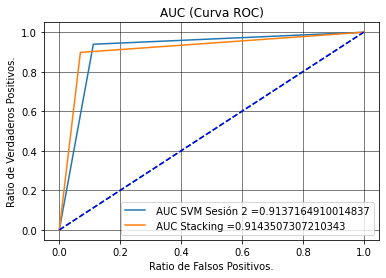

In [ ]:
test_svm_f, test_svm_t, te_thresholds_svm = roc_curve(y_eval, pred_svm)
test_stack_f, test_stack_t, te_thresholds_stack = roc_curve(y_eval, pred_sc)

plt.grid()
plt.plot(test_svm_f, test_svm_t, label=" AUC SVM Sesión 2 ="+str(auc(test_svm_f, test_svm_t)))
plt.plot([0,1],[0,1],'g--')
plt.plot(test_stack_f, test_stack_t, label=" AUC Stacking ="+str(auc(test_stack_f, test_stack_t)))
plt.plot([0,1],[0,1],'b--')
plt.legend()
plt.xlabel("Ratio de Falsos Positivos.")
plt.ylabel("Ratio de Verdaderos Positivos.")
plt.title("AUC (Curva ROC)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Observando la curva ROC y evalando el AUC, podemos ver que los modelos son prácticamente iguales y que tienen una calidad semejante, por lo que nos encontramos ante dos modelos muy potentes. El anterior tiene una pequeña tendencia hacia los valores etiquetados como 0 y el nuevo, hacia los valores etiquetados como 1. No obstante, son dos modelos prácticamente iguales y con una calidad semejante.


---


Por otro lado, el modelo obtenido con el Boosting resulta ser mejor que el modelo de la sesión anterior obtenido usando MLP. De esta forma, eliminamos el modelo de MLP anterior de la ecuación y tomamos este como el segundo mejor y lo usaremos para compararlo con el mejor de combinación de clasificadores con Word Embedding Mediana.

### Validación Modelo Boosting (2º mejor modelo)

Dado que el AdaBoost usa el resampling dentro de su algoritmo, no tiene sentido realizar el k-fold, ya que todos esos "folds" ya han sido entrenados y sería como entrenar dos veces. Asumimos que no está sobreajustado, pero probamos la curva ROC para evaluar la calidad del modelo.

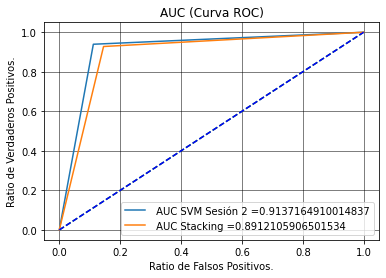

In [ ]:
test_svm_f, test_svm_t, te_thresholds_svm = roc_curve(y_eval, pred_svm)
test_boost_f, test_boost_t, te_thresholds_boost = roc_curve(y_eval, pred_sc_b)

plt.grid()
plt.plot(test_svm_f, test_svm_t, label=" AUC SVM Sesión 2 ="+str(auc(test_svm_f, test_svm_t)))
plt.plot([0,1],[0,1],'g--')
plt.plot(test_boost_f, test_boost_t, label=" AUC Stacking ="+str(auc(test_boost_f, test_boost_t)))
plt.plot([0,1],[0,1],'b--')
plt.legend()
plt.xlabel("Ratio de Falsos Positivos.")
plt.ylabel("Ratio de Verdaderos Positivos.")
plt.title("AUC (Curva ROC)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Observando la curva ROC y evalando el AUC, podemos ver que los modelos son muy parecidos y que tienen una calidad semejante, por lo que nos encontramos ante dos modelos muy potentes. 


---

## Combinación de Clasificadores para Representación con Word Embedding - Mediana

In [ ]:
data2 = np.append(data_med, extra_Data, axis=1)
X, y = data2[0:3817,0:300], data2[0:3817,300:301]
print(data_med.shape, data2.shape)

(3817, 300) (3817, 301)


In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
x_train, x_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3, random_state=42)

### Bagging

In [ ]:
clf2 = BaggingClassifier(base_estimator=svm.SVC(),n_estimators=10)
clf2.fit(x_train, y_train)

BaggingClassifier(base_estimator=SVC())

In [ ]:
pred2 = clf2.predict(x_eval)
acc_sig_svm2 = clf2.score(x_eval, y_eval)
pred_sc2 = pred2
print("Training set score: %f" % clf2.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm2)
print("F1 Score Macro:", f1_score(y_eval, pred2, average='macro'))
print("F1 Score Micro:", f1_score(y_eval, pred2, average='micro'))
print("F1 Score:", f1_score(y_eval, pred2, average=None))
print("\n", confusion_matrix(y_eval, pred_sc2))
print(classification_report(y_eval, pred_sc2))

Training set score: 0.855583
Accuracy Radial Basis Kernel: 0.8137032842582106
F1 Score Macro: 0.8132908636519491
F1 Score Micro: 0.8137032842582106
F1 Score: [0.80451575 0.82206598]

 [[677 199]
 [130 760]]
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80       876
         1.0       0.79      0.85      0.82       890

    accuracy                           0.81      1766
   macro avg       0.82      0.81      0.81      1766
weighted avg       0.82      0.81      0.81      1766



### Boosting

In [ ]:
tree2 = DecisionTreeClassifier(max_depth=5, random_state=0)
ada2 = AdaBoostClassifier(base_estimator=tree2, n_estimators=500, learning_rate=1.5, random_state=1)
ada2.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         random_state=0),
                   learning_rate=1.5, n_estimators=500, random_state=1)

In [ ]:
pred3 = ada2.predict(x_eval)
acc_sig_svm3 = ada2.score(x_eval, y_eval)
pred_sc3 = pred3
print("Training set score: %f" % ada2.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm3)
print("F1 Score Macro:", f1_score(y_eval, pred3, average='macro'))
print("F1 Score Micro:", f1_score(y_eval, pred3, average='micro'))
print("F1 Score:", f1_score(y_eval, pred3, average=None))
print("\n", confusion_matrix(y_eval, pred_sc3))
print(classification_report(y_eval, pred_sc3))

Training set score: 0.998544
Accuracy Radial Basis Kernel: 0.8850509626274066
F1 Score Macro: 0.884994875266061
F1 Score Micro: 0.8850509626274066
F1 Score: [0.88245512 0.88753463]

 [[762 114]
 [ 89 801]]
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88       876
         1.0       0.88      0.90      0.89       890

    accuracy                           0.89      1766
   macro avg       0.89      0.88      0.88      1766
weighted avg       0.89      0.89      0.89      1766



### Stacking

In [ ]:
treeStack2 = DecisionTreeClassifier(max_depth=5, random_state=0)
estimators2 = [('mlp',MLPClassifier(random_state=1, max_iter=1000)),('svr', svm.SVC())]
stack2 = StackingClassifier ( estimators=estimators2, final_estimator=treeStack2 )
stack2.fit(x_train, y_train)

StackingClassifier(estimators=[('mlp',
                                MLPClassifier(max_iter=1000, random_state=1)),
                               ('svr', SVC())],
                   final_estimator=DecisionTreeClassifier(max_depth=5,
                                                          random_state=0))

In [ ]:
pred4 = stack2.predict(x_eval)
acc_sig_svm4 = stack2.score(x_eval, y_eval)
pred_sc4 = pred4
print("Training set score: %f" % stack2.score( x_train, y_train ) )
print('Accuracy Radial Basis Kernel:', acc_sig_svm4)
print("F1 Score Macro:", f1_score(y_eval, pred4, average='macro'))
print("F1 Score Micro:", f1_score(y_eval, pred4, average='micro'))
print("F1 Score:", f1_score(y_eval, pred4, average=None))
print("\n", confusion_matrix(y_eval, pred_sc4))
print(classification_report(y_eval, pred_sc4))

Training set score: 0.965534
Accuracy Radial Basis Kernel: 0.8799546998867497
F1 Score Macro: 0.8799540840211111
F1 Score Micro: 0.8799546998867497
F1 Score: [0.88022599 0.87968218]

 [[779  97]
 [115 775]]
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       876
         1.0       0.89      0.87      0.88       890

    accuracy                           0.88      1766
   macro avg       0.88      0.88      0.88      1766
weighted avg       0.88      0.88      0.88      1766



A la vista de los resultados, podemos observar que usando la técnica de Boosting (AdaBoost) obtenemos el mejor modelo de los 3. Por su parte, tal y como habíamos dicho, si lo comparamos con el 2º mejor modelo de WE Ponderado, vemos que el mejor de los dos es el Ponderado, como se puede observar a continuación:

Mejor modelo WE Mediana - Boosting

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       876
         1.0       0.89      0.87      0.88       890

2º Mejor Modelo WE Ponderado - Boosting

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.89       894
         1.0       0.86      0.93      0.89       873

De esta forma, descartamos el modelo de WE con Mediana y nos quedamos por tanto, con los 3 modelos del WE Ponderado: 

- 1º: Modelo con Stacking WE Ponderada.
- 2º: Modelo Entrenado en la sesión 3 con SVM.
- 3º: Modelo con Boosting WE Ponderada.


## Relación final de Modelos

Estos son nuestros 3 modelos elegidos con el **Word Embedding Ponderado**:

1. El modelo entrenado con Stacking  

              precision    recall  f1-score

         0.0       0.90      0.93      0.92
         1.0       0.93      0.90      0.91

2. El modelo entrenado con SVM en la sesión 3

                precision    recall  f1-score

         0.0       0.94      0.89      0.91
         1.0       0.89      0.94      0.91

3. El modelo entrenado con Boosting  

              precision    recall  f1-score

         0.0       0.92      0.85      0.89
         1.0       0.86      0.93      0.89


### Comparativa de modelos con las Curvas ROC y AUC 

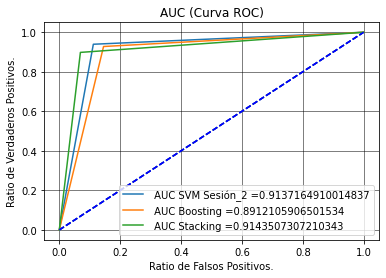

In [ ]:
test_svm_f, test_svm_t, te_thresholds_svm = roc_curve(y_eval, pred_svm)
test_boost_f, test_boost_t, te_thresholds_boost = roc_curve(y_eval, pred_sc_b)
test_stack_f, test_stack_t, te_thresholds_stack = roc_curve(y_eval, pred_sc)

plt.grid()
plt.plot(test_svm_f, test_svm_t, label=" AUC SVM Sesión_2 ="+str(auc(test_svm_f, test_svm_t)))
plt.plot([0,1],[0,1],'g--')
plt.plot(test_boost_f, test_boost_t, label=" AUC Boosting ="+str(auc(test_boost_f, test_boost_t)))
plt.plot([0,1],[0,1],'b--')
plt.plot(test_stack_f, test_stack_t, label=" AUC Stacking ="+str(auc(test_stack_f, test_stack_t)))
plt.plot([0,1],[0,1],'b--')
plt.legend()
plt.xlabel("Ratio de Falsos Positivos.")
plt.ylabel("Ratio de Verdaderos Positivos.")
plt.title("AUC (Curva ROC)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()